In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
# set attributes
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
surf_indices = slab.get_surface_atoms()
print(f"surface indices {surf_indices}")
fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

# c = FixAtoms(indices=fix_indices)
# slab_batch.set_constraint(c)

# set tags, so that we can identify the surface atoms
slab_batch.set_tags([1 if i in surf_indices else 0 for i in range(num_bulk_atoms)])

surface = SurfaceSystem(
    slab_batch, ads_positions, nff_surf_calc, system_settings=system_settings
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

2024-05-23 14:05:28,225|INFO|initializing 64 virtual atoms
2024-05-23 14:05:28,257|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-05-23 14:05:28,258|INFO|number of pristine atoms is 60
2024-05-23 14:05:28,258|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 15 16 17 18 19 20 21 24 25 26 27 28
 30 31 32 33 34 35 36 39 40 41 42 43 45 46 47 48 49 50 51 54 55 56 57 58]
2024-05-23 14:05:28,259|INFO|surface indices are [ 7  8 14 22 23 29 37 38 44 52 53 59]


surface indices [ 7  8 14 22 23 29 37 38 44 52 53 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
      Step     Time          Energy         fmax
BFGS:    0 14:05:29     -467.521881        0.2306
BFGS:    1 14:05:30     -467.527832        0.1610
BFGS:    2 14:05:30     -467.533936        0.1001
BFGS:    3 14:05:30     -467.535400        0.1234
BFGS:    4 14:05:30     -467.539459        0.1376
BFGS:    5 14:05:30     -467.541412        0.0825
BFGS:    6 14:05:30     -467.542236        0.0278
BFGS:    7 14:05:30     -467.542328        0.0162
BFGS:    8 14:05:30     -467.542389        0.0149
BFGS:    9 14:05:30     -467.542389        0.0125
BFGS:   10 14:05:30     -467.542450        0.0158
BFGS:   11 14:05:30     -467.542480        0.0177
BFGS:   12 14:05:31     -467.542511        0.0134
BFGS:   13 14:05:31     -467.542511        0.0088


In [7]:
surface.get_potential_energy()

array([-467.543], dtype=float32)

In [8]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [9]:
surface.get_surface_energy()

array([12.469], dtype=float32)

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-05-23 14:05:33,791|INFO|there are 60 atoms in pristine slab
2024-05-23 14:05:33,793|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-05-23 14:05:33,794|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 14:05:33     -467.521881        0.2306
BFGS:    1 14:05:34     -467.527832        0.1610
BFGS:    2 14:05:34     -467.533936        0.1001
BFGS:    3 14:05:34     -467.535400        0.1234
BFGS:    4 14:05:34     -467.539459        0.1376
BFGS:    5 14:05:34     -467.541412        0.0825
BFGS:    6 14:05:34     -467.542236        0.0278
BFGS:    7 14:05:34     -467.542328        0.0162
BFGS:    8 14:05:34     -467.542389        0.0149
BFGS:    9 14:05:34     -467.542389        0.0125
BFGS:   10 14:05:34     -467.542450        0.0158
BFGS:   11 14:05:34     -467.542480        0.0177
BFGS:   12 14:05:35     -467.542511        0.0134
BFGS:   13 14:05:35     -467.542511        0.0088


2024-05-23 14:05:35,206|INFO|running for 5 iterations per run over a total of 10 runs
2024-05-23 14:05:35,207|INFO|starting with iteration 0
2024-05-23 14:05:35,208|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 14:05:35     -469.719147        4.8163
BFGS:    1 14:05:35     -470.530853        3.1330
BFGS:    2 14:05:35     -471.005402        1.2214
BFGS:    3 14:05:35     -471.101776        1.1047
BFGS:    4 14:05:35     -471.430573        0.9090
BFGS:    5 14:05:35     -471.538940        0.8113
BFGS:    6 14:05:35     -471.555573        1.0589
BFGS:    7 14:05:35     -471.642365        0.5232
BFGS:    8 14:05:36     -471.672455        0.5075
BFGS:    9 14:05:36     -471.738190        0.4638
BFGS:   10 14:05:36     -471.761230        0.4230
BFGS:   11 14:05:36     -471.819672        0.5089
BFGS:   12 14:05:36     -471.833527        0.3141
BFGS:   13 14:05:36     -471.847137        0.2391
BFGS:   14 14:05:36     -471.860992        0.2493
BFGS:   15 14:05:36     -471.866608        0.2502
BFGS:   16 14:05:36     -471.873657        0.2011
BFGS:   17 14:05:36     -471.879517        0.2042
BFGS:

2024-05-23 14:05:47,718|INFO|current energy is 11.76690673828125, calculated energy is 11.76690673828125
2024-05-23 14:05:47,718|INFO|optim structure has Energy = 11.767+/-0.094
2024-05-23 14:05:47,719|INFO|average force error = 0.067
2024-05-23 14:05:47,729|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:05:47     -472.195068        8.6535
BFGS:    1 14:05:47     -474.274902        3.1737
BFGS:    2 14:05:48     -474.922211        1.8780
BFGS:    3 14:05:48     -475.337616        1.6925
BFGS:    4 14:05:48     -475.555939        1.4826
BFGS:    5 14:05:48     -475.940887        0.7580
BFGS:    6 14:05:48     -476.095184        0.8443
BFGS:    7 14:05:48     -476.204224        0.9164
BFGS:    8 14:05:48     -476.290039        0.9195
BFGS:    9 14:05:48     -476.470428        1.1191
BFGS:   10 14:05:48     -476.596893        1.4565
BFGS:   11 14:05:48     -476.776489        1.7196
BFGS:   12 14:05:48     -476.964966        1.6399
BFGS:   13 14:05:49     -477.437866        2.0297
BFGS:   14 14:05:49     -477.777954        1.7483
BFGS:   15 14:05:49     -477.937958        1.4208
BFGS:   16 14:05:49     -478.082428        1.0403
BFGS:   17 14:05:49     -478.278046        1.3868
BFGS:   18 14:05:49     -478.465790        1.4280
B

2024-05-23 14:06:00,375|INFO|current energy is 5.247802734375, calculated energy is 5.24749755859375
2024-05-23 14:06:00,376|INFO|optim structure has Energy = 5.247+/-0.294
2024-05-23 14:06:00,376|INFO|average force error = 0.054
2024-05-23 14:06:00,390|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:06:00     -466.968414       51.8016
BFGS:    1 14:06:00     -479.995728       19.7133
BFGS:    2 14:06:00     -485.464874        9.9947
BFGS:    3 14:06:00     -488.783691        3.1336
BFGS:    4 14:06:00     -490.023193        2.2593
BFGS:    5 14:06:00     -490.821198        2.2648
BFGS:    6 14:06:01     -491.286957        2.6056
BFGS:    7 14:06:01     -491.921478        2.5061
BFGS:    8 14:06:01     -492.379059        2.2533
BFGS:    9 14:06:01     -492.782928        1.8962
BFGS:   10 14:06:01     -493.501251        1.8292
BFGS:   11 14:06:01     -493.915131        2.0627
BFGS:   12 14:06:01     -494.273590        2.0965
BFGS:   13 14:06:01     -494.655426        1.7869
BFGS:   14 14:06:01     -494.968964        1.5307
BFGS:   15 14:06:01     -495.300995        1.7379
BFGS:   16 14:06:02     -495.514893        1.3760
BFGS:   17 14:06:02     -495.654449        0.8510
BFGS:   18 14:06:02     -495.780396        0.7985
B

2024-05-23 14:06:13,484|INFO|current energy is 1.36920166015625, calculated energy is 1.369232177734375
2024-05-23 14:06:13,485|INFO|optim structure has Energy = 1.369+/-0.275
2024-05-23 14:06:13,486|INFO|average force error = 0.072
2024-05-23 14:06:13,497|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:06:13     -390.636505      188.4107
BFGS:    1 14:06:13     -433.623871       59.1035
BFGS:    2 14:06:13     -458.839478       50.6523
BFGS:    3 14:06:13     -473.076080       35.1984
BFGS:    4 14:06:13     -482.202667       22.8378
BFGS:    5 14:06:14     -487.851959       13.7286
BFGS:    6 14:06:14     -491.333374        8.3518
BFGS:    7 14:06:14     -493.503326        6.1518
BFGS:    8 14:06:14     -494.779510        5.1395
BFGS:    9 14:06:14     -495.675201        4.7487
BFGS:   10 14:06:14     -496.727570        4.0219
BFGS:   11 14:06:14     -497.926270        3.2943
BFGS:   12 14:06:14     -498.899292        3.6789
BFGS:   13 14:06:14     -500.033783        3.3960
BFGS:   14 14:06:14     -500.695770        3.4082
BFGS:   15 14:06:14     -501.641388        3.5028
BFGS:   16 14:06:15     -502.132416        3.2788
BFGS:   17 14:06:15     -502.936676        3.2839
BFGS:   18 14:06:15     -503.494354        3.3013
B

2024-05-23 14:06:25,157|INFO|current energy is 1.36920166015625, calculated energy is 1.369171142578125
2024-05-23 14:06:25,158|INFO|optim structure has Energy = 1.369+/-0.275
2024-05-23 14:06:25,159|INFO|average force error = 0.072
2024-05-23 14:06:25,172|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:06:25     -435.117950       49.2750
BFGS:    1 14:06:25     -463.868500       30.1492
BFGS:    2 14:06:25     -475.595856       17.0672
BFGS:    3 14:06:25     -483.596344        8.9348
BFGS:    4 14:06:25     -488.543793        4.8218
BFGS:    5 14:06:25     -491.728638        3.2865
BFGS:    6 14:06:25     -493.880615        4.0281
BFGS:    7 14:06:25     -495.473511        4.0459
BFGS:    8 14:06:26     -496.546539        3.9294
BFGS:    9 14:06:26     -497.849243        3.1124
BFGS:   10 14:06:26     -499.233643        2.7815
BFGS:   11 14:06:26     -500.327301        2.7242
BFGS:   12 14:06:26     -500.990265        2.6254
BFGS:   13 14:06:26     -501.636597        2.5287
BFGS:   14 14:06:26     -502.458649        2.0646
BFGS:   15 14:06:26     -502.874420        2.1127
BFGS:   16 14:06:26     -503.465942        1.7100
BFGS:   17 14:06:26     -503.876129        1.9060
BFGS:   18 14:06:26     -504.353851        2.4897
B

2024-05-23 14:06:37,902|INFO|current energy is 4.628082275390625, calculated energy is 4.6280517578125
2024-05-23 14:06:37,903|INFO|optim structure has Energy = 4.628+/-0.338
2024-05-23 14:06:37,903|INFO|average force error = 0.059
2024-05-23 14:06:37,918|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:06:38     -421.671478       76.4664
BFGS:    1 14:06:38     -451.557709       34.1096
BFGS:    2 14:06:38     -473.208893       20.3281
BFGS:    3 14:06:38     -483.665680       11.7117
BFGS:    4 14:06:38     -491.272095        6.9264
BFGS:    5 14:06:38     -495.698944        4.3708
BFGS:    6 14:06:38     -498.519135        3.6200
BFGS:    7 14:06:38     -500.405426        3.8018
BFGS:    8 14:06:38     -501.899384        3.7233
BFGS:    9 14:06:38     -503.393707        3.5196
BFGS:   10 14:06:38     -504.953247        3.0964
BFGS:   11 14:06:39     -506.430573        2.8543
BFGS:   12 14:06:39     -507.599518        2.8648
BFGS:   13 14:06:39     -508.398956        2.5849
BFGS:   14 14:06:39     -509.229248        2.5021
BFGS:   15 14:06:39     -509.925903        2.2568
BFGS:   16 14:06:39     -510.507599        2.1149
BFGS:   17 14:06:39     -510.983490        1.8552
BFGS:   18 14:06:39     -511.325836        2.0464
B

2024-05-23 14:06:49,757|INFO|current energy is 5.67254638671875, calculated energy is 5.67254638671875
2024-05-23 14:06:49,758|INFO|optim structure has Energy = 5.673+/-0.359
2024-05-23 14:06:49,759|INFO|average force error = 0.065
2024-05-23 14:06:49,771|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:06:49     -423.525848       66.7476
BFGS:    1 14:06:49     -455.559723       31.5270
BFGS:    2 14:06:50     -475.090485       17.0431
BFGS:    3 14:06:50     -487.070709       12.8980
BFGS:    4 14:06:50     -494.466827        4.9519
BFGS:    5 14:06:50     -498.953827        3.7811
BFGS:    6 14:06:50     -501.366547        2.3777
BFGS:    7 14:06:50     -502.304596        2.4591
BFGS:    8 14:06:50     -503.576508        2.3109
BFGS:    9 14:06:50     -504.535034        2.3651
BFGS:   10 14:06:50     -505.826996        2.5139
BFGS:   11 14:06:50     -506.687592        1.9496
BFGS:   12 14:06:50     -507.171051        1.5596
BFGS:   13 14:06:51     -507.827393        2.1487
BFGS:   14 14:06:51     -508.165405        2.0606
BFGS:   15 14:06:51     -508.795410        2.7690
BFGS:   16 14:06:51     -509.141113        2.1392
BFGS:   17 14:06:51     -509.749603        1.5018
BFGS:   18 14:06:51     -509.989166        1.3738
B

2024-05-23 14:07:01,366|INFO|current energy is 6.2369384765625, calculated energy is 6.2369384765625
2024-05-23 14:07:01,367|INFO|optim structure has Energy = 6.237+/-0.345
2024-05-23 14:07:01,367|INFO|average force error = 0.064
2024-05-23 14:07:01,375|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:07:01      985.834412    25514.2990
BFGS:    1 14:07:01     -402.046600      238.0479
BFGS:    2 14:07:01     -436.033173      229.7014
BFGS:    3 14:07:01     -456.458160      238.2088
BFGS:    4 14:07:01     -468.265106      265.2718
BFGS:    5 14:07:01     -478.748322      171.2875
BFGS:    6 14:07:02     -484.181274      159.2275
BFGS:    7 14:07:02     -487.348145      160.4564
BFGS:    8 14:07:02     -490.404877      103.4712
BFGS:    9 14:07:02     -492.025391       60.4407
BFGS:   10 14:07:02     -493.658600       22.7057
BFGS:   11 14:07:02     -495.037018        5.1486
BFGS:   12 14:07:02     -496.278961       33.7123
BFGS:   13 14:07:02     -497.161163       34.9865
BFGS:   14 14:07:02     -498.087860       33.0664
BFGS:   15 14:07:02     -498.903717       30.6207
BFGS:   16 14:07:02     -499.403320       23.9137
BFGS:   17 14:07:02     -500.072266        3.2343
BFGS:   18 14:07:03     -500.597382       30.9779
B

2024-05-23 14:07:13,691|INFO|current energy is 4.50689697265625, calculated energy is 4.50689697265625
2024-05-23 14:07:13,692|INFO|optim structure has Energy = 4.507+/-0.518
2024-05-23 14:07:13,692|INFO|average force error = 0.120
2024-05-23 14:07:13,700|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:07:13     -376.681671      107.8804
BFGS:    1 14:07:13     -404.907379      129.7394
BFGS:    2 14:07:14     -433.678314       38.1941
BFGS:    3 14:07:14     -463.149658       41.8280
BFGS:    4 14:07:14     -484.107330       26.7068
BFGS:    5 14:07:14     -498.183380       12.1191
BFGS:    6 14:07:14     -507.791473        6.8802
BFGS:    7 14:07:14     -514.109802        5.1631
BFGS:    8 14:07:14     -517.760193        3.6877
BFGS:    9 14:07:14     -520.011169        3.5258
BFGS:   10 14:07:14     -521.592346        3.7666
BFGS:   11 14:07:14     -523.063477        3.3930
BFGS:   12 14:07:14     -524.416565        2.7237
BFGS:   13 14:07:15     -525.576782        3.0757
BFGS:   14 14:07:15     -527.005432        3.7317
BFGS:   15 14:07:15     -528.219116        3.4724
BFGS:   16 14:07:15     -528.750732        2.9491
BFGS:   17 14:07:15     -529.689514        2.0510
BFGS:   18 14:07:15     -530.135315        2.0633
B

2024-05-23 14:07:25,156|INFO|current energy is 3.53759765625, calculated energy is 3.53759765625
2024-05-23 14:07:25,156|INFO|optim structure has Energy = 3.538+/-0.406
2024-05-23 14:07:25,157|INFO|average force error = 0.100
2024-05-23 14:07:25,165|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 14:07:25     -360.661285      121.6334
BFGS:    1 14:07:25     -411.795410       49.1115
BFGS:    2 14:07:25     -445.019135       29.1984
BFGS:    3 14:07:25     -472.641632       20.4141
BFGS:    4 14:07:25     -493.830658       18.0519
BFGS:    5 14:07:25     -508.165070       12.3449
BFGS:    6 14:07:25     -517.296082        7.7665
BFGS:    7 14:07:26     -523.353699        5.7212
BFGS:    8 14:07:26     -527.291992        4.1401
BFGS:    9 14:07:26     -529.233887        3.4133
BFGS:   10 14:07:26     -530.269104        2.5540
BFGS:   11 14:07:26     -531.546692        2.1025
BFGS:   12 14:07:26     -532.219055        3.1080
BFGS:   13 14:07:26     -533.619812        3.9448
BFGS:   14 14:07:26     -534.574402        3.8372
BFGS:   15 14:07:26     -535.798279        2.3715
BFGS:   16 14:07:26     -536.545227        1.8982
BFGS:   17 14:07:27     -537.328247        2.3768
BFGS:   18 14:07:27     -537.983215        2.4949
B

2024-05-23 14:07:38,227|INFO|current energy is 4.8050537109375, calculated energy is 4.8050537109375
2024-05-23 14:07:38,227|INFO|optim structure has Energy = 4.805+/-0.309
2024-05-23 14:07:38,228|INFO|average force error = 0.088


Time taken = 124.74758985824883 seconds


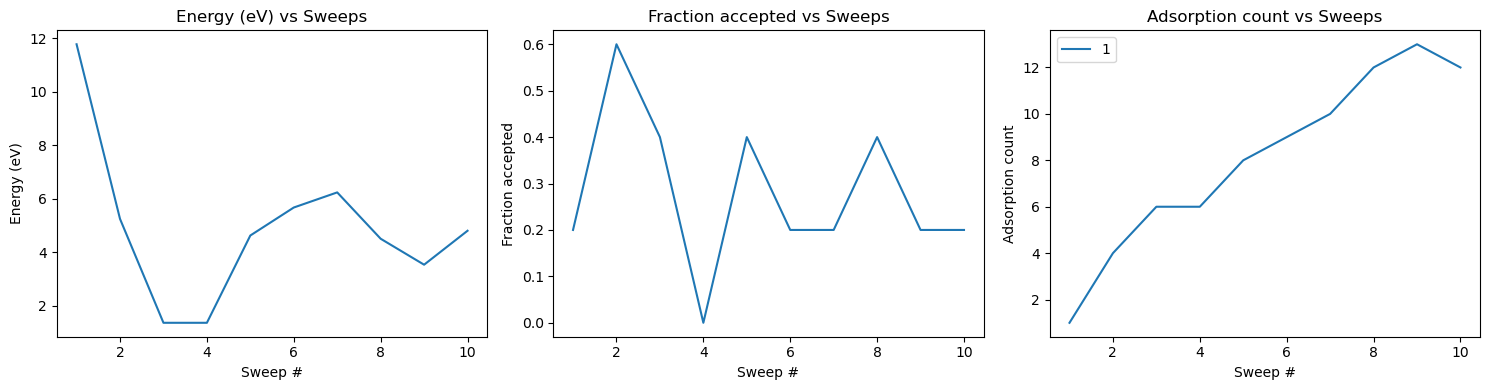

In [10]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [ ]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)